In [84]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import config
import utility.df
import utility.iolib
import utility.plotlib
from utility.feature import Feature
from utility.feature import FeatureCM

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

In [85]:
# Setup configuration
cfg = config.ResearchConfig
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=False)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

# Initialise feature obj
feature = Feature(df_datesFrame)

feature.add_usageTime(df_lesson1, df_incomp1)
feature.add_progressions(df_lesson1)
feature.add_age(df_pupils)
feature.add_mathAge(df_lesson1, df_incomp1)
feature.add_outcome(df_lesson1)
feature.add_score(df_lesson1, df_incomp1)
feature.add_hardship(df_lesson1)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

In summary, there are 1380/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|█████████▉| 4287/4305 [00:08<00:00, 401.87it/s]C:\Users\User\Anaconda3\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 4305/4305 [00:11<00:00, 389.19it/s]


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved  in a file. The file has been loaded!
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: math age.
+ Add feature: outcome.
+ Add feature: score.
+ Add feature: hardship.


In [86]:
df_whizz = pd.DataFrame()
nmonth = df_subspt1.customer_month.max()
#nmonth = 2

warnings.filterwarnings('ignore')
for cmonth in tqdm(range(1, nmonth+1)):
    
    ftrCM = FeatureCM(feature, cmonth, df_subspt1, cfg)

    ftrCM.add_usageTime()
    ftrCM.add_progress()
    ftrCM.add_age()
    ftrCM.add_outcome()
    ftrCM.add_score()
    ftrCM.add_hardship()
    ftrCM.add_mathAge()
    
    df = ftrCM.df_whizz_
    
    df_whizz = pd.concat([df_whizz, df], axis=0)
warnings.filterwarnings('default')

100%|██████████| 49/49 [00:44<00:00,  1.10it/s]


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


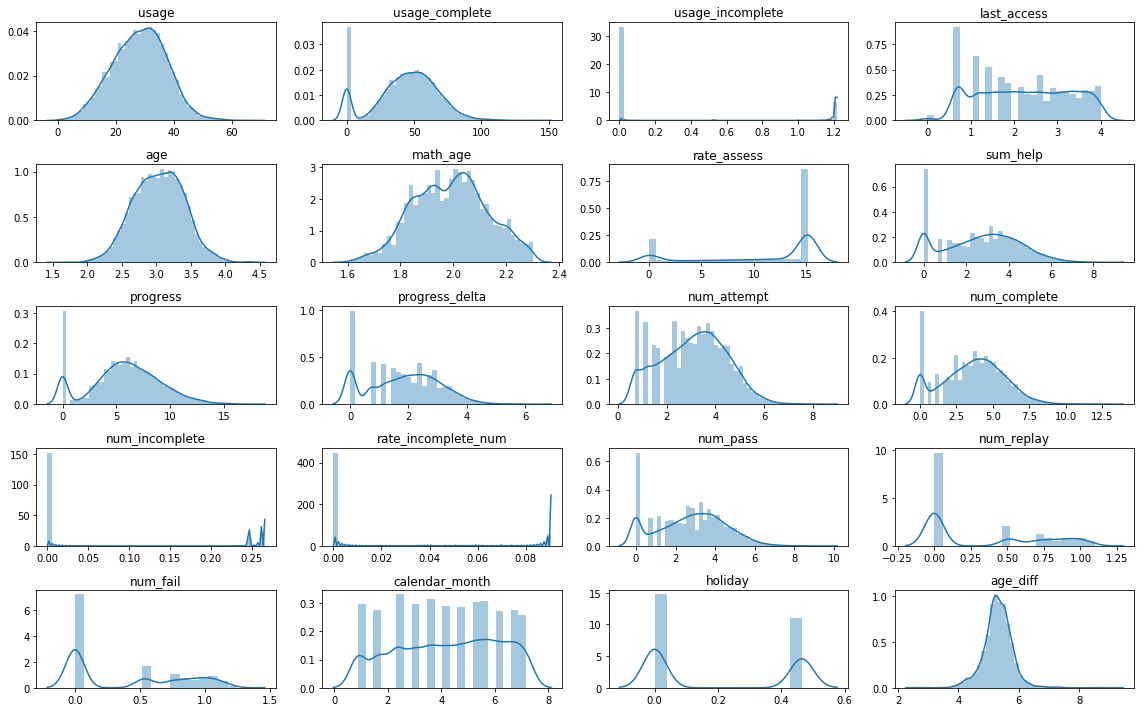

In [88]:
df_whizz1 = df_whizz.set_index(['customer_month'], append=True, inplace=False)
df_whizz1 = df_whizz.reset_index()
df_whizz1.set_index(['customer_month', 'pupilId'], inplace=True)


# One hot encoding on calendar month
#df_cal_month = pd.get_dummies(df_whizz1['calendar_month'])
#df_whizz1 = pd.concat([df_cal_month, df_whizz1], axis=1)

#mask = (~df_whizz1['ave_stackDepth'].isna()) & \
#       (~df_whizz1['rate_fail'].isna()) & \
#       (~df_whizz1['rate_pass'].isna())
#df_whizz1 = df_whizz1[mask]

from scipy.stats import boxcox
import seaborn as sns
import mglearn

ftr_list = ['usage', 'usage_complete', 'usage_incomplete',
            'last_access', 
            'age', 'math_age',
            'rate_assess', 'sum_help', 
            'progress', 'progress_delta',
            'num_attempt',  'num_complete', 'num_incomplete', 'rate_incomplete_num', 
            'num_pass', 'num_replay', 'num_fail',
            'calendar_month',
            'holiday',
            'age_diff'
           ]
ftr_list_nontransform = ['age', 'math_age', 'age_diff']
#ftr_list = ['num_fail', 'progress', 'last_access']
ftr_list_nontransform = []

X = []
Xt = []

n_col = 4
n_ftr = len(ftr_list)
n_row = n_ftr // n_col
n_row +=  n_ftr % n_col
pos = range(1, n_ftr+1)

fig = plt.figure(figsize=(4*n_col,2*n_row))
for i, ftr in enumerate(ftr_list):
    ax = fig.add_subplot(n_row, n_col, pos[i])
    x = df_whizz1[ftr].values + 1
    
    if ftr in ftr_list_nontransform:
        sns.distplot(x)
        ax.set_title(ftr)
    else:
        if ftr == 'age_diff':
            x += 10
        xt,_ = boxcox(x)
        Xt.append(xt)
        sns.distplot(xt)
        ax.set_title(ftr)
        
    X.append(x)
plt.tight_layout()
    
X = np.array(X).transpose()
Xt = np.array(Xt).transpose()
y = df_whizz1.churn.values

## PCA on features

Text(0,0.5,'Principal components')

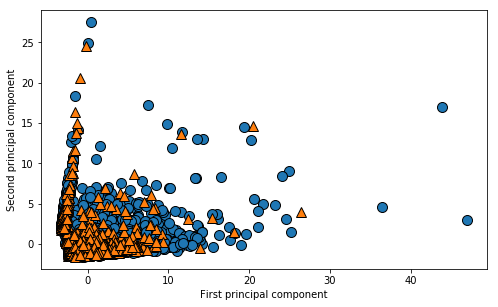

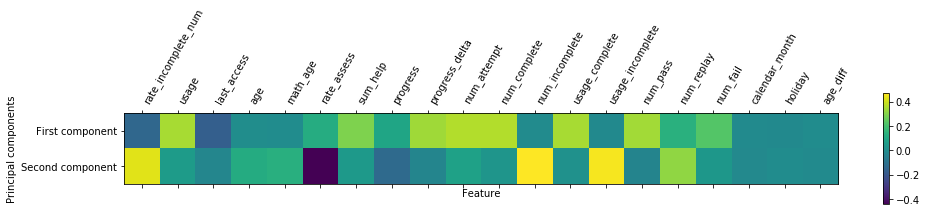

In [7]:
# apply PCA to the dataset for visualisation
# i.e. reduce the number of dimensions to 2

# scale data to have unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # only keep the first two principal components
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# plot the first vs. second pc, colored by class
plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:,0], X_pca[:,1], y)
plt.gca().set_aspect('equal')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

# visualise the 'importance' attribute of original features to each principal component

plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1], ['First component', 'Second component'])
plt.colorbar()
plt.xticks(range(len(ftr_list)), ftr_list, rotation=60, ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal components')

## Pre-process data

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Decision Tree

In-sample accuracy:  0.8909844107707402
Out-sample accuracy:  0.8796599084368869
Feature importance:  [0.         0.         0.         0.57705599 0.0730487  0.06568882
 0.03320687 0.         0.11039008 0.         0.         0.02195396
 0.04519467 0.         0.         0.         0.         0.
 0.01354562 0.0599153 ]


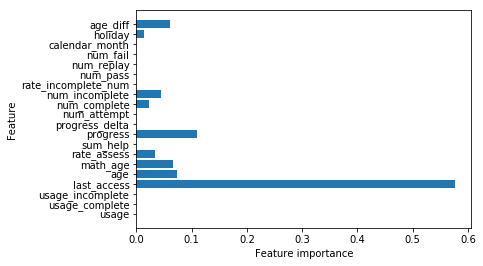

In [83]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=0) # the random_state here is used for tie-breaking internally
tree.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', tree.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', tree.score(X_test_scaled, y_test))

print("Feature importance: ", tree.feature_importances_)

def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), ftr_list)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    
plot_feature_importances(tree)

In-sample accuracy:  0.8947999563937643
Out-sample accuracy:  0.8884892086330936


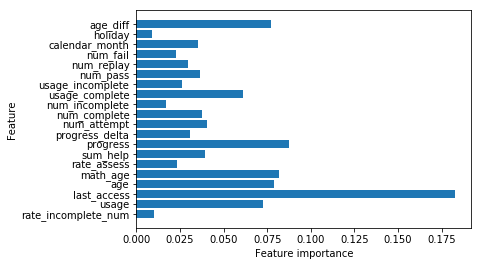

In [15]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=1000, random_state=0, max_depth=10)
forest.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', forest.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', forest.score(X_test_scaled, y_test))

plot_feature_importances(forest)

In-sample accuracy:  0.8870598495584868
Out-sample accuracy:  0.8878351863963375


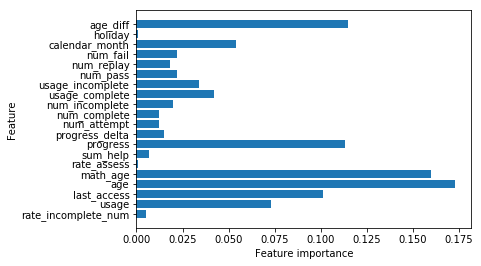

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1, learning_rate=0.1, n_estimators=1000)
gbrt.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', gbrt.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', gbrt.score(X_test_scaled, y_test))

plot_feature_importances(gbrt)

In-sample accuracy:  0.8857516624877357
Out-sample accuracy:  0.8878351863963375


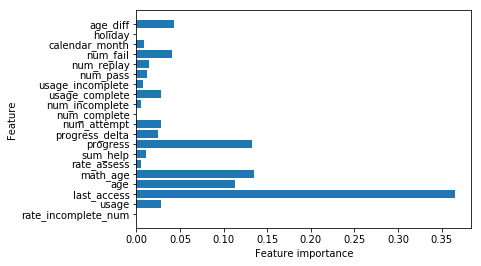

In [30]:
from sklearn.ensemble import AdaBoostClassifier

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', bdt.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', bdt.score(X_test_scaled, y_test))

plot_feature_importances(bdt)

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


0.1    0.0
Name: progress, dtype: float64

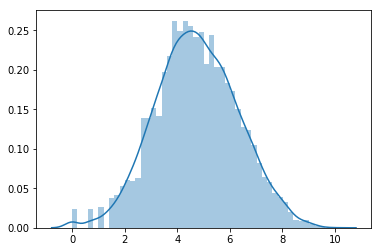

In [59]:
x = df_whizz1.progress
#sns.distplot(x[x!=0])

xt, _ = boxcox(x[x!=0])
sns.distplot(xt)

x.quantile([.1])

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


0.1    0.0
Name: usage_incomplete, dtype: float64

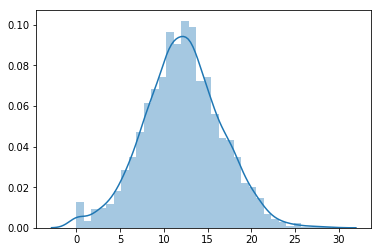

In [60]:
x = df_whizz1.usage_incomplete
#sns.distplot(x[x!=0])

xt, _ = boxcox(x[x!=0])
sns.distplot(xt)

x.quantile([.1])

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


0.1    0.0
Name: usage_complete, dtype: float64

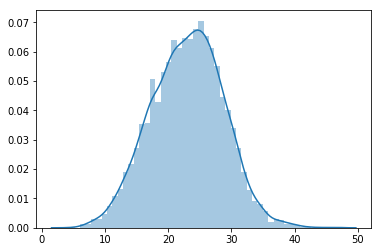

In [61]:
x = df_whizz1.usage_complete
#sns.distplot(x[x!=0])

xt, _ = boxcox(x[x!=0])
sns.distplot(xt)

x.quantile([.1])

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


0.999    394.32
Name: sum_help, dtype: float64

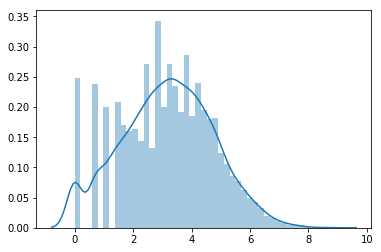

In [81]:
x = df_whizz1.sum_help
#sns.distplot(x[(x!=0)&(x<200)])

xt, _ = boxcox(x[(x!=0)])
sns.distplot(xt)

x.quantile([.999])